**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook trains and prepares the model to assign lead scores in used car dealership web application.  

- Input: 
    - Lead scoring dataset downloaded from https://www.kaggle.com/datasets/amritachatterjee09/lead-scoring-dataset.
- Ouput
    - Processed lead scoring dataset
    - Trained TRF
    - Pretrained ARF. This is the model deployed in the web service. 

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 5 minutes in Jupyter Notebook with 8 processor cores.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [1]:
import sys
print(sys.executable)

C:\Users\User\miniconda3\envs\arf_conda_env\python.exe


## Import

In [2]:
# Standard libraries
import math
import os
import pickle
import time

import numpy as np
import pandas as pd

# scikit-learn model
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# River model and its components
from river.ensemble import AdaptiveRandomForestClassifier
from river.drift import ADWIN

# User libraries
from data_preprocessing import DataPreprocessor
from arf_cf_transfer_learning import transfer_learning, transfer_tree_weights_test, dt_fetch_data
from arf_training import train_arf_cf
from rf_cf_performance_eval import analyze_trees, measure_performance

Initialize constants.

In [3]:
RANDOM_SEED = 2022
INPUT_FOLDER_PATH = 'inputs'
INPUT_DATASET = 'lead_scoring.csv'

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'lead_scoring'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

## Data Setup

### Change Dataset Theme

The lead scoring dataset used can be found at https://www.kaggle.com/datasets/amritachatterjee09/lead-scoring-dataset. Unfortunately, this lead scoring dataset's theme is not car dealership. Instead, the lead scoring dataset, in which the theme is online education, is manually inspected and modified to change the theme to car dealership.  

Below is the important background information of the lead scoring dataset.
- The company sells online courses specifically to industry professionals.
- Visitors can browse the courses and watch free-trial videos.
- New lead is created when a visitor submits a form containing their contact information which are email address or phone number.
- The salesperson tries to convert the new lead by making phone calls or sending promotional emails.
- The company wants to identity "hot leads" instead of trying to convert all of them.
- The company wants to use the dataset to train a model that assigns lead scores to the leads.

The background information justifies the use of this dataset in the car dealership application. It is because the purpose of using the dataset is the same even though the theme is different. 

In [4]:
ls_ds_education = pd.read_csv(f'{INPUT_FOLDER_PATH}/{INPUT_DATASET}')
ls_ds_education.head(5)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


The description of each feature is shown below:

<table><tr><th style="text-align:left;font-weight: bold;">No</th><th style="text-align:left;font-weight: bold;">Feature Name</th><th style="text-align:left;font-weight: bold;">Description</th></tr><tr><td style="text-align:left;">1</td><td style="text-align:left;">Prospect ID</td><td style="text-align:left;">A unique ID with which the customer is identified.</td></tr><tr><td style="text-align:left;">2</td><td style="text-align:left;">Lead Number</td><td style="text-align:left;">A lead number assigned to each lead procured.</td></tr><tr><td style="text-align:left;">3</td><td style="text-align:left;">Lead Origin</td><td style="text-align:left;">The origin identifier with which the customer was identified to be a lead. Includes API,Landing Page Submission, etc.</td></tr><tr><td style="text-align:left;">4</td><td style="text-align:left;">Lead Source</td><td style="text-align:left;">The source of the lead. Includes Google, Organic Search, Olark Chat, etc.</td></tr><tr><td style="text-align:left;">5</td><td style="text-align:left;">Do Not Email</td><td style="text-align:left;">An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.</td></tr><tr><td style="text-align:left;">6</td><td style="text-align:left;">Do Not Call</td><td style="text-align:left;">An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.</td></tr><tr><td style="text-align:left;">7</td><td style="text-align:left;">Converted</td><td style="text-align:left;">The target variable. Indicates whether a lead has been successfully converted or not.</td></tr><tr><td style="text-align:left;">8</td><td style="text-align:left;">TotalVisits</td><td style="text-align:left;">The total number of visits made by the customer on the website.</td></tr><tr><td style="text-align:left;">9</td><td style="text-align:left;">Total Time Spent on Website</td><td style="text-align:left;">The total time spent by the customer on the website.</td></tr><tr><td style="text-align:left;">10</td><td style="text-align:left;">Page Views Per Visit</td><td style="text-align:left;">Average number of pages on the website viewed during the visits.</td></tr><tr><td style="text-align:left;">11</td><td style="text-align:left;">Last Activity</td><td style="text-align:left;">Last activity performed by the customer. Includes Email Opened, Olark ChatConversation, etc.</td></tr><tr><td style="text-align:left;">12</td><td style="text-align:left;">Country</td><td style="text-align:left;">The country of the customer.</td></tr><tr><td style="text-align:left;">13</td><td style="text-align:left;">Specialization</td><td style="text-align:left;">The industry domain in which the customer worked before. Includes the level'Select Specialization' which means the customer had not selected this option while filling the form.</td></tr><tr><td style="text-align:left;">14</td><td style="text-align:left;">How did you hear about X Education</td><td style="text-align:left;">The source from which the customer heard about X Education.</td></tr><tr><td style="text-align:left;">15</td><td style="text-align:left;">What is your current occupation</td><td style="text-align:left;">Indicates whether the customer is a student, unemployed or employed.</td></tr><tr><td style="text-align:left;">16</td><td style="text-align:left;">What matters most to you in choosing a course</td><td style="text-align:left;">An option selected by the customer indicating what is their main motto behind doing this course.</td></tr><tr><td style="text-align:left;">17</td><td style="text-align:left;">Search</td><td style="text-align:left;">Indicating whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">18</td><td style="text-align:left;">Magazine</td><td style="text-align:left;">Indicating whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">19</td><td style="text-align:left;">Newspaper Article</td><td style="text-align:left;">Indicates whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">20</td><td style="text-align:left;">X Education Forums</td><td style="text-align:left;">Indicates whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">21</td><td style="text-align:left;">Newspaper</td><td style="text-align:left;">Indicating whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">22</td><td style="text-align:left;">Digital Advertisement</td><td style="text-align:left;">Indicates whether the customer had seen the ad in any of the listed items.</td></tr><tr><td style="text-align:left;">23</td><td style="text-align:left;">Through Recommendations</td><td style="text-align:left;">Indicates whether the customer came in through recommendations.</td></tr><tr><td style="text-align:left;">24</td><td style="text-align:left;">Receive More Updates About Our Courses</td><td style="text-align:left;">Indicates whether the customer chose to receive more updates about the courses.</td></tr><tr><td style="text-align:left;">25</td><td style="text-align:left;">Tags</td><td style="text-align:left;">Tags assigned to customers indicating the current status of the lead.</td></tr><tr><td style="text-align:left;">26</td><td style="text-align:left;">Lead Quality</td><td style="text-align:left;">Indicates the quality of lead based on the data and intuition the employee who has been assigned to the lead.</td></tr><tr><td style="text-align:left;">27</td><td style="text-align:left;">Update me on Supply Chain Content</td><td style="text-align:left;">Indicates whether the customer wants updates on the Supply Chain Content.</td></tr><tr><td style="text-align:left;">28</td><td style="text-align:left;">Get updates on DM Content</td><td style="text-align:left;">Indicates whether the customer wants updates on the DM Content.</td></tr><tr><td style="text-align:left;">29</td><td style="text-align:left;">Lead Profile</td><td style="text-align:left;">A lead level assigned to each customer based on their profile.</td></tr><tr><td style="text-align:left;">30</td><td style="text-align:left;">City</td><td style="text-align:left;">The city of the customer.</td></tr><tr><td style="text-align:left;">31</td><td style="text-align:left;">Asymmetrique Activity Index</td><td style="text-align:left;">An index and score assigned to each customer based on their activity and their profile</td></tr><tr><td style="text-align:left;">32</td><td style="text-align:left;">Asymmetrique Profile Index</td><td style="text-align:left;">An index and score assigned to each customer based on their activity and their profile.</td></tr><tr><td style="text-align:left;">33</td><td style="text-align:left;">Asymmetrique Activity Score</td><td style="text-align:left;">An index and score assigned to each customer based on their activity and their profile.</td></tr><tr><td style="text-align:left;">34</td><td style="text-align:left;">Asymmetrique Profile Score</td><td style="text-align:left;">An index and score assigned to each customer based on their activity and their profile.</td></tr><tr><td style="text-align:left;">35</td><td style="text-align:left;">I agree to pay the amount through cheque</td><td style="text-align:left;">Indicates whether the customer has agreed to pay the amount through cheque or not.</td></tr><tr><td style="text-align:left;">36</td><td style="text-align:left;">a free copy of Mastering The Interview</td><td style="text-align:left;">Indicates whether the customer wants a free copy of 'Mastering the Interview' or not.</td></tr><tr><td style="text-align:left;">37</td><td style="text-align:left;">Last Notable Activity</td><td style="text-align:left;">The last notable activity performed by the student.</td></tr></table>

To change the dataset theme to car dealership, 12 attributes are kept, 24 attributes are deleted, and 1 attributes are kept and modified.
Below is the list of features to be dropped and their reasons:

<table>
      <tr>
            <th style="text-align:left;font-weight: bold;">No</th>
            <th style="text-align:left;font-weight: bold;">Feature Name</th>
            <th style="text-align:left;font-weight: bold;">Action</th>
            <th style="text-align:left;font-weight: bold;">Description</th>
      </tr>
      <tr>
            <td style="text-align:left;">1</td>
            <td style="text-align:left;">Prospect ID</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">ID is not useful.</td>
      </tr>
      <tr>
            <td style="text-align:left;">2</td>
            <td style="text-align:left;">Lead Number</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">ID is not useful.</td>
      </tr>
      <tr>
            <td style="text-align:left;">3</td>
            <td style="text-align:left;">Lead Origin</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">Around 40% the lead orginated from API, which does not match the car dealership application logic. The feature is not "transferable".</td>
      </tr>
      <tr>
            <td style="text-align:left;">4</td>
            <td style="text-align:left;">Lead Source</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">Example of lead source is Bing, Facebook, Google, Live Chat. The lead source is not useful in scoring leads.</td>
      </tr>
      <tr>
            <td style="text-align:left;">5</td>
            <td style="text-align:left;">Do Not Email</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">An indicator variable selected by the customer wherein they select whether of
                  not they want to be emailed about the course or not.</td>
      </tr>
      <tr>
            <td style="text-align:left;">6</td>
            <td style="text-align:left;">Do Not Call</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">An indicator variable selected by the customer wherein they select whether of
                  not they want to be called about the course or not.</td>
      </tr>
      <tr>
            <td style="text-align:left;">7</td>
            <td style="text-align:left;">Converted</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">The target variable. Indicates whether a lead has been successfully converted
                  or not.</td>
      </tr>
      <tr>
            <td style="text-align:left;">8</td>
            <td style="text-align:left;">TotalVisits</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">The total number of visits made by the customer on the website.</td>
      </tr>
      <tr>
            <td style="text-align:left;">9</td>
            <td style="text-align:left;">Total Time Spent on Website</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">The total time spent by the customer on the website.</td>
      </tr>
      <tr>
            <td style="text-align:left;">10</td>
            <td style="text-align:left;">Page Views Per Visit</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Average number of pages on the website viewed during the visits.</td>
      </tr>
      <tr>
            <td style="text-align:left;">11</td>
            <td style="text-align:left;">Last Activity</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education.</td>
      </tr>
      <tr>
            <td style="text-align:left;">12</td>
            <td style="text-align:left;">Country</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The dataset theme is within a country which is Malaysia.</td>
      </tr>
      <tr>
            <td style="text-align:left;">13</td>
            <td style="text-align:left;">Specialization</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The customers' careers specialization has nothing to do with car dealership.</td>
      </tr>
      <tr>
            <td style="text-align:left;">14</td>
            <td style="text-align:left;">How did you hear about X Education</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">This feature contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">15</td>
            <td style="text-align:left;">What is your current occupation</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicates whether the customer is a student, unemployed or employed.</td>
      </tr>
      <tr>
            <td style="text-align:left;">16</td>
            <td style="text-align:left;">What matters most to you in choosing a course</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education.</td>
      </tr>
      <tr>
            <td style="text-align:left;">17</td>
            <td style="text-align:left;">Search</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicating whether the customer had seen the ad in any of the listed items.
            </td>
      </tr>
      <tr>
            <td style="text-align:left;">18</td>
            <td style="text-align:left;">Magazine</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">This feature contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">19</td>
            <td style="text-align:left;">Newspaper Article</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicates whether the customer had seen the ad in any of the listed items.</td>
      </tr>
      <tr>
            <td style="text-align:left;">20</td>
            <td style="text-align:left;">X Education Forums</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education.</td>
      </tr>
      <tr>
            <td style="text-align:left;">21</td>
            <td style="text-align:left;">Newspaper</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicating whether the customer had seen the ad in any of the listed items.
            </td>
      </tr>
      <tr>
            <td style="text-align:left;">22</td>
            <td style="text-align:left;">Digital Advertisement</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicates whether the customer had seen the ad in any of the listed items.</td>
      </tr>
      <tr>
            <td style="text-align:left;">23</td>
            <td style="text-align:left;">Through Recommendations</td>
            <td style="text-align:left;">Keep</td>
            <td style="text-align:left;">Indicates whether the customer came in through recommendations.</td>
      </tr>
      <tr>
            <td style="text-align:left;">24</td>
            <td style="text-align:left;">Receive More Updates About Our Courses</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">This feature contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">25</td>
            <td style="text-align:left;">Tags</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education.</td>
      </tr>
      <tr>
            <td style="text-align:left;">26</td>
            <td style="text-align:left;">Lead Quality</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education. In addition, the assigned lead quality is based on the employee's intuition who is working in a education sector.</td>
      </tr>
      <tr>
            <td style="text-align:left;">27</td>
            <td style="text-align:left;">Update me on Supply Chain Content</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education. This feature also contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">28</td>
            <td style="text-align:left;">Get updates on DM Content</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education. This feature also contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">29</td>
            <td style="text-align:left;">Lead Profile</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education.</td>
      </tr>
      <tr>
            <td style="text-align:left;">30</td>
            <td style="text-align:left;">City</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The dataset theme is within a country which is Malaysia.</td>
      </tr>
      <tr>
            <td style="text-align:left;">31</td>
            <td style="text-align:left;">Asymmetrique Activity Index</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">No information is provided on how to calculate the value.</td>
      </tr>
      <tr>
            <td style="text-align:left;">32</td>
            <td style="text-align:left;">Asymmetrique Profile Index</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">No information is provided on how to calculate the value.</td>
      </tr>
      <tr>
            <td style="text-align:left;">33</td>
            <td style="text-align:left;">Asymmetrique Activity Score</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">No information is provided on how to calculate the value.</td>
      </tr>
      <tr>
            <td style="text-align:left;">34</td>
            <td style="text-align:left;">Asymmetrique Profile Score</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">No information is provided on how to calculate the value.</td>
      </tr>
      <tr>
            <td style="text-align:left;">35</td>
            <td style="text-align:left;">I agree to pay the amount through cheque</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is online education. This feature also contains faulty values.</td>
      </tr>
      <tr>
            <td style="text-align:left;">36</td>
            <td style="text-align:left;">a free copy of Mastering The Interview</td>
            <td style="text-align:left;">Modify</td>
            <td style="text-align:left;">Change the name to "A free copy of car specification".</td>
      </tr>
      <tr>
            <td style="text-align:left;">37</td>
            <td style="text-align:left;">Last Notable Activity</td>
            <td style="text-align:left;">Delete</td>
            <td style="text-align:left;">The feature's theme is in online education.</td>
      </tr>
</table>

In [5]:
delete_cols = [
    'Prospect ID',
    'Lead Number',
    'Lead Origin',
    'Lead Source',
    'Last Activity',
    'Country',
    'Specialization',
    'How did you hear about X Education',
    'What matters most to you in choosing a course',
    'Magazine',
    'X Education Forums',
    'Receive More Updates About Our Courses',
    'Tags',
    'Lead Quality',
    'Update me on Supply Chain Content',
    'Get updates on DM Content',
    'Lead Profile',
    'City',
    'Asymmetrique Activity Index',
    'Asymmetrique Profile Index',
    'Asymmetrique Activity Score',
    'Asymmetrique Profile Score',
    'I agree to pay the amount through cheque',
    'Last Notable Activity'
]

new_col_name = [
    'dont_email',
    'dont_call',
    'converted',
    'total_site_visit',
    'total_time_spend_on_site',
    'avg_page_view_per_visit',
    'occupation',
    'seen_ads',
    'seen_news_article',
    'seen_news',
    'seen_digital_ads',
    'customer_referral',
    'received_free_copy'
]

# Delete the columns
ls_ds = ls_ds_education.drop(columns=delete_cols, axis=1)
# Rename the columns
ls_ds.columns = new_col_name
ls_ds

,dont_email,dont_call,converted,total_site_visit,total_time_spend_on_site,avg_page_view_per_visit,occupation,seen_ads,seen_news_article,seen_news,seen_digital_ads,customer_referral,received_free_copy
0,No,No,0,0.0,0,0.00,Unemployed,No,No,No,No,No,No
1,No,No,0,5.0,674,2.50,Unemployed,No,No,No,No,No,No
2,No,No,1,2.0,1532,2.00,Student,No,No,No,No,No,Yes
3,No,No,0,1.0,305,1.00,Unemployed,No,No,No,No,No,No
4,No,No,1,2.0,1428,1.00,Unemployed,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,Yes,No,1,8.0,1845,2.67,Unemployed,No,No,No,No,No,No
9236,No,No,0,2.0,238,2.00,Unemployed,No,No,No,No,No,Yes
9237,Yes,No,0,2.0,199,2.00,Unemployed,No,No,No,No,No,Yes
9238,No,No,1,3.0,499,3.00,NaN,No,No,No,No,No,No


In [6]:
ls_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dont_email                9240 non-null   object 
 1   dont_call                 9240 non-null   object 
 2   converted                 9240 non-null   int64  
 3   total_site_visit          9103 non-null   float64
 4   total_time_spend_on_site  9240 non-null   int64  
 5   avg_page_view_per_visit   9103 non-null   float64
 6   occupation                6550 non-null   object 
 7   seen_ads                  9240 non-null   object 
 8   seen_news_article         9240 non-null   object 
 9   seen_news                 9240 non-null   object 
 10  seen_digital_ads          9240 non-null   object 
 11  customer_referral         9240 non-null   object 
 12  received_free_copy        9240 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 938.6+ KB


### Preprocess Data

In [7]:
cat_attrs = ['dont_email','dont_call','occupation','seen_ads','seen_news_article',
            'seen_news','seen_digital_ads','customer_referral','received_free_copy']
num_attrs = ['total_site_visit', 'total_time_spend_on_site', 'avg_page_view_per_visit']
target_attr = 'converted'

Based on the output below:

1. The features which are `dont_call`, `seen_ads`, `seen_news_article`, `seen_news`, `seen_digital_ads`, `customer_referral` are severely imbalanced. These features must be dropped since Chi-square goodness of fit test will be used in monitoring drift. The test will be both inaccurate and high in variance since the expected value on one category is less than 20 and the expected value is over thousands in another category. Note that the `dont_call` column is still retained but not used as a feature. It is because the column is one of the input fields in the web application.


2. For the `occupation`, there is no easy way to impute the value. To ensure that the explainer's output makes much more sense, the feature value `Housewife`, `Other`, and `NaN` is removed. 

In [8]:
for cat_attr in cat_attrs+[target_attr]:
    print(ls_ds[cat_attr].value_counts(dropna=False))
    print()

No     8506
Yes     734
Name: dont_email, dtype: int64

No     9238
Yes       2
Name: dont_call, dtype: int64

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: occupation, dtype: int64

No     9226
Yes      14
Name: seen_ads, dtype: int64

No     9238
Yes       2
Name: seen_news_article, dtype: int64

No     9239
Yes       1
Name: seen_news, dtype: int64

No     9236
Yes       4
Name: seen_digital_ads, dtype: int64

No     9233
Yes       7
Name: customer_referral, dtype: int64

No     6352
Yes    2888
Name: received_free_copy, dtype: int64

0    5679
1    3561
Name: converted, dtype: int64



Drop `dont_call`, `seen_ads`, `seen_news_article`, `seen_news`, `seen_digital_ads`, and `customer_referral` columns.

In [9]:
dropped_cat_cols = ['seen_ads', 'seen_news_article', 'seen_news', 
                    'seen_digital_ads', 'customer_referral']

# Update the categorical feature names
cat_attrs = list(set(cat_attrs) - set(dropped_cat_cols))
cat_attrs.remove('dont_call')
cat_attrs = sorted(cat_attrs, reverse=False)

# Drop the categorical columns
ls_ds = ls_ds.drop(columns=dropped_cat_cols, axis=1)

The output shows the final preprocessed dataset. It consists of 6524 samples and 7 columns. Note that the target variable is not balanced (5679:3561) before the preprocessing. After removing the irrelevant values in the `occupation` feature, the target variable becomes balanced (3353:3171). 

In [10]:
# Remove irrelevant feature values
ls_ds = ls_ds[~ls_ds['occupation'].isin(['Housewife', 'Other', np.NaN])]

for cat_attr in cat_attrs+[target_attr]:
    print(ls_ds[cat_attr].value_counts(dropna=False))
    print()

No     6061
Yes     463
Name: dont_email, dtype: int64

Unemployed              5600
Working Professional     706
Student                  210
Businessman                8
Name: occupation, dtype: int64

No     4362
Yes    2162
Name: received_free_copy, dtype: int64

0    3353
1    3171
Name: converted, dtype: int64



The output below shows that there is null values in the `total_site_visit` and `avg_page_view_per_visit`. Simple imputer provided by Scikit-Learn API is used to impute the missing values using the mean feature value in the dataset. 

In [11]:
ls_ds[num_attrs].isna().sum()

total_site_visit            128
total_time_spend_on_site      0
avg_page_view_per_visit     128
dtype: int64

In [12]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Impute the missing value
ls_ds_num = simple_imputer.fit_transform(ls_ds.loc[:, num_attrs])
# Update the dataframe
ls_ds = ls_ds.drop(columns=num_attrs , axis=1)
for i in range(0, len(num_attrs)):
    ls_ds[num_attrs[i]] = ls_ds_num[:, i]

In [13]:
ls_ds[num_attrs].isna().sum()

total_site_visit            0
total_time_spend_on_site    0
avg_page_view_per_visit     0
dtype: int64

# Training

## TRF

Train a traditional random forest on the train set. Then, perform the transfer learning to transfer the training weights to the adaptive random forest.

Split the dataset into train and test set.

In [14]:
# Get X and y
X = ls_ds.drop(columns=target_attr, axis=1)
X_attrs = X.columns
y = ls_ds[target_attr]
# Get train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, 
                                                    random_state=RANDOM_SEED)

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns = X_attrs)
X_test = pd.DataFrame(X_test, columns = X_attrs)

# Export the train and test set for later use
train_set = X_train.copy()
train_set[target_attr] = y_train
train_set.to_csv(os.path.join(OUT_FOLDER_PATH, 'train_set.csv'), index=False)

test_set = X_test.copy()
test_set[target_attr] = y_test
test_set.to_csv(os.path.join(OUT_FOLDER_PATH, 'test_set.csv'), index=False)

X_train = X_train.drop(columns='dont_call', axis=1)
X_test = X_test.drop(columns='dont_call', axis=1)

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (5219, 6)
y_train shape (5219,)
X_test shape (1305, 6)
y_test shape (1305,)


Below are the hyperparameters for traditional random forest.

In [15]:
trf_cf_params = {
    # Random forest hyperparameters
    'n_estimators': 100, # Train 100 decision trees
    'criterion': 'gini', # The feature selection criterion was Gini impurity
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'random_state': RANDOM_SEED,
    
    # Traditional random forest algorithm-specific hyperparameters
    'bootstrap': True, # Different subset of dataset in each tree
    'max_leaf_nodes': None, # Can produce unlimited number of leaf nodes
    'min_samples_leaf': 1, # Miminum number of samples required to be at leaf node
    'min_samples_split': 50, # Minimum number of samples to split node. Must match with grace period.
    'min_weight_fraction_leaf': 0.0, # Samples have equal weight at leaf node

    # Utility parameters
    'n_jobs': -1, # Use all available processors
    'verbose': 0,
    'warm_start': False, # Fit a whole new forest
}

Perform hyperparameter tunning to optimise TRF.

In [16]:
# Setup the data preprocessor
ls_data_pp = DataPreprocessor(X_train, num_attrs, cat_attrs)

# Relevant hyperparameters to reduce generalisation errors
trf_cf_param_dist = {
    'n_estimators': [5, 10, 15, 20], # The number of decision trees
    'max_depth': [5, 10, 15, 20], # The maximum depth of decision trees
}

# Training
duration = 0
start = time.time()

trf_cf_cv = RandomizedSearchCV(
    RandomForestClassifier(**trf_cf_params), trf_cf_param_dist, 
    n_iter = 8, scoring = 'roc_auc', n_jobs = -1, 
    refit=True, cv = 10, verbose = 10, 
    random_state = RANDOM_SEED, return_train_score = False)

X_train_pp = ls_data_pp.preprocess(X_train)

trf_cf_search = trf_cf_cv.fit(X_train_pp, y_train)

end = time.time()
duration += end - start
print(f'\nTime taken for tunning TRF: {duration} seconds')

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Time taken for tunning TRF: 5.637105703353882 seconds


Fit the TRF using the best hyperparamter settings.

In [17]:
# Training
duration = 0
start = time.time()

# Update the hyperparameters
for param_name, param_value in trf_cf_search.best_params_.items():
    trf_cf_params[param_name] = param_value

# Define a classifier
trf_cf = RandomForestClassifier(**trf_cf_params)

trf_cf.fit(X_train_pp, y_train)

end = time.time()
duration += end - start

print(f'\nTime taken for training TRF: {duration} seconds')


Time taken for training TRF: 0.20335745811462402 seconds


Below is the overall description of the fitted TRF classifier.

In [18]:
total_depth = 0
total_estimators = trf_cf.n_estimators
print(f'The total number of base learners is {trf_cf.n_estimators}.')

for estimator in trf_cf.estimators_:
    total_depth += estimator.get_depth()

print(f'The depth of each base learner is {math.floor(total_depth/total_estimators)} on average.')

The total number of base learners is 20.
The depth of each base learner is 5 on average.


## ARF (Train from Scratch)

An ARF model is trained from scratch to serve as the baseline model for pre-trained model. The performance of the pre-trained model should be as good as or better than the baseline model. Below are the hyperparameters for adaptive random forest.

In [19]:
river_adwin = ADWIN(delta = 0.002)

river_arf_cf_params = {
    # Random forest hyperparameters
    'n_models': len(trf_cf.estimators_), # Number of base learners
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'seed': RANDOM_SEED,
    'split_criterion': 'gini', # Set criterion as Gini impurity

    # Adaptive random forest algorithm-specific hyperparamters
    'binary_split': True, # Enforce binary split and disable multi-way split
    'disable_weighted_vote': True, # Disable weighted vote prediction
    'drift_detector': river_adwin, # Drift Detection method.
    'grace_period': 50, # Number of instances a leaf should observe between split attempts
    'lambda_value': 6, # The lambda value for bagging
    'leaf_prediction': 'mc', # Perform Naive Bayes Adaptive prediction at the leaves
    'split_confidence': 0.01, # Allowed error in split decision
    'splitter': None, # Use tree.splitter.GaussianSplitter to monitor the class statistics and perform splits
    'tie_threshold': 0.05, # Threshold below which a split will be forced to break ties. 
    'warning_detector': river_adwin, # Warning Detection method.

    # Utility hyperparameters
    'max_size': 100, # Maximum memory (MB) consumed by the tree.
    'nominal_attributes': ls_data_pp.nominal_attrs # List of nominal attributes.
}

In [20]:
new_arf_cf = AdaptiveRandomForestClassifier(**river_arf_cf_params)

X_train_pp = ls_data_pp.preprocess(X_train)

arf_cf_trained_fr_scratch, runninng_metrics_new_arf_train = train_arf_cf(new_arf_cf, X_train_pp, y_train)

Training adaptive random forest algorithm: 100%|█| 5219/5219 [00:37<00:00, 137.


## ARF (Transfer Learning)

Perform transfer learning to get the pre-trained ARF. 

In [21]:
arf_cf = AdaptiveRandomForestClassifier(**river_arf_cf_params)

# Override the max features and initialize the base learners
feature_names = ls_data_pp.features
nominal_attrs = ls_data_pp.nominal_attrs
arf_cf._init_ensemble(feature_names)

# Transfer weight from traditional random forest to adaptive random forest
train_preprocessed = ls_data_pp.preprocess(X_train)
train_preprocessed['y'] = y_train

arf_cf = transfer_learning(arf_cf, trf_cf, train_preprocessed, feature_names, nominal_attrs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    4.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    6.7s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    7.3s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    7.4s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    7.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    9.7s remaining:    1.6s



Time taken for performing transfer learning: 10.414580583572388 seconds


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.3s finished


In [22]:
# Save data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'wb') as f:
    pickle.dump(ls_data_pp, f)

# Save traditional random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trf_cf.pkl'), 'wb') as f:
    pickle.dump(trf_cf, f)

# Save pretrained adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_cf.pkl'), 'wb') as f:
    pickle.dump(arf_cf, f)
    
# Save adaptive random forest that is trained from scratch    
with open(os.path.join(OUT_FOLDER_PATH, 'arf_cf_trained_fr_scratch.pkl'), 'wb') as f:
    pickle.dump(arf_cf_trained_fr_scratch, f)

### Validation

Three tests are conducted to validate the pre-trained adaptive random forest classifier.

**Test 1**:  ARF can train on new samples after performing transfer learning.

In [23]:
# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_cf.pkl'), 'rb') as f:
    arf_cf_tmp = pickle.load(f)

X_test_d_pp = ls_data_pp.preprocess(X_test)

# Try training using the first thousand of the samples
train_arf_cf(arf_cf_tmp, X_test_d_pp[:100], y_test[:100])

Training adaptive random forest algorithm: 100%|█| 100/100 [00:02<00:00, 41.45i


(AdaptiveRandomForestClassifier([ForestMemberClassifier (
                                   index_original=0
                                   model=BaseTreeClassifier (
                                     max_features=3
                                     grace_period=50
                                     max_depth=inf
                                     split_criterion="gini"
                                     split_confidence=0.01
                                     tie_threshold=0.05
                                     leaf_prediction="mc"
                                     nb_threshold=0
                                     nominal_attributes=['dont_email_Yes', 'occupation_Businessman', 'occupation_Student', 'occupation_Unemployed', 'occupation_Working Professional', 'received_free_copy_Yes']
                                     splitter=GaussianSplitter (
                                       n_splits=10
                                     )
                       

**Test 2**:  The number of nodes must be the same by comparing the attribute for the respective base learners.

In [24]:
node_counts = {
    'TRF': [],
    'ARF': [],
    'match': []
}

for idx, (dt, ht) in enumerate(zip(trf_cf.estimators_, arf_cf)):
    dt_nc = dt.tree_.node_count
    ht_nc = ht.model.n_nodes
    node_counts['TRF'].append(dt_nc)
    node_counts['ARF'].append(ht_nc)
    node_counts['match'].append(dt_nc == ht_nc)

node_counts = pd.DataFrame(node_counts)
node_counts.index = [idx + 1 for idx in range(len(arf_cf))]
node_counts

,TRF,ARF,match
1,39,39,True
2,45,45,True
3,41,41,True
4,45,45,True
5,43,43,True
6,43,43,True
7,39,39,True
8,41,41,True
9,39,39,True
10,41,41,True


**Test 3**: All the nodes are placed at the right place in the ARF. Both file contents must look the same to prove the right placements of all nodes. Each record in the file represents the location of the current internal node, and its children nodes' indexes and counts.

In [25]:
# Initialize a new ARF to prevent overwriting on existing ARF
arf_cf_tmp = AdaptiveRandomForestClassifier(**river_arf_cf_params)

# Override the max features and initialize the base learners
feature_names = ls_data_pp.features
nominal_attrs = ls_data_pp.nominal_attrs
arf_cf_tmp._init_ensemble(feature_names)

# Fetch the first decision tree to perform the testing
decision_tree = trf_cf.estimators_[0]

transfer_tree_weights_test(
    arf_cf_tmp[0].model,
    decision_tree,
    train_preprocessed,
    trf_cf.classes_, 
    feature_names, 
    nominal_attrs, 
    log_file_path=f'{OUT_PARENT_DIR}/{OUT_CHILD_DIR}/arf_debug.txt'
)


Time taken for testing the transfer learning: 2.191354751586914 seconds


In [26]:
dt = trf_cf.estimators_[0].tree_

queue = [(0, '')]

total_nodes = 0

with open(os.path.join(OUT_FOLDER_PATH, 'trf_debug.txt'), 'w') as f:
    while len(queue) > 0:
        node_idx, node_location = queue.pop(0)
        total_nodes += 1

        left_ch_idx  = dt.children_left[node_idx]
        right_ch_idx = dt.children_right[node_idx]

        if left_ch_idx != -1:
            new_node_location = node_location + '0'
            df_node_l = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_l.shape[0] != 0:
                queue.append((left_ch_idx, new_node_location))

        if right_ch_idx != -1:
            new_node_location = node_location + '1'
            df_node_r = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_r.shape[0] != 0:
                queue.append((right_ch_idx, new_node_location))

        # Write the record if and only if the current node is not the leaf node
        if left_ch_idx != -1 and right_ch_idx != -1:
            f.write(f'Node location: {node_location}\n')
            f.write(f'Left  child index: {left_ch_idx}\nCount: {df_node_l.shape[0]}\n')
            f.write(f'Right child index: {right_ch_idx}\nCount: {df_node_r.shape[0]}\n\n')

# Evaluation

`cf_pred_res` is a dictionary that stores predictions and metrics for two different subsets of data.

The two subset of data are:
- Train data.
- Test data.

In [27]:
MODEL_TYPES = ['TRF', 'ARF_pretrained', 'ARF_fr_scratch']
cf_pred_res = {}
# First level
DATA_TYPES = ['train', 'test']
# Second level
RECORD_TYPES = ['model', 'pred', 'pred_proba', 'fpr', 'tpr', 'roc_auc', 'label']

# Initialise cf_pred_res
for data_type in DATA_TYPES:
    cf_pred_res[data_type] = {}
    for record_type in RECORD_TYPES:
        cf_pred_res[data_type][record_type] = {}

cf_pred_res

{'train': {'model': {},
  'pred': {},
  'pred_proba': {},
  'fpr': {},
  'tpr': {},
  'roc_auc': {},
  'label': {}},
 'test': {'model': {},
  'pred': {},
  'pred_proba': {},
  'fpr': {},
  'tpr': {},
  'roc_auc': {},
  'label': {}}}

## Train performance

The output compares the train performance between TRF and ARF in the offline setting. The result exactly match with the one conducted in the experiment.


The output compares the training performance between TRF and ARF in the offline setting. It can be inferred that the transfer learning process is **successful** as the ROC AUC scores of both **TRF** and **pretrained ARF** are the same. The performance is the same since the prediction value of every node is directly copied from the **TRF** to the **pretrained ARF**. Furthermore, the leaf prediction mechanisms of both **TRF** and **ARF** are configured as majority class prediction. On the other hand, the training performance of **ARF that is trained from scratch** is similar to the performance **pretrained ARF** with a negligible difference of 1%. 

Combining the results that are observed from *FYP2_ARF_CF_Performance_Analysis.ipynb*, it can be inferred that the initial performance boost provided by transfer learning varies from one dataset to another. Regardless, transfer learning algorithm is useful in situations where the performance is absolutely critical (e.g. data science competitions, banking system).

Performing predictions: 100%|█████████████| 5219/5219 [00:12<00:00, 404.07it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0                0.819          0.819          0.828  0.687          0.687   
1                0.724          0.724          0.719  0.843          0.843   
macro avg        0.771          0.771          0.773  0.765          0.765   
weighted avg     0.772          0.772          0.774  0.764          0.764   

Metrics                     f1-score                               support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch     TRF   
0                     0.676    0.747          0.747          0.744  2649.0   
1                     0.855    0.779          0.779          0.781  2570.0   
macro avg             0.765    0.763          0.763          0.762  5219.0   
weighted avg          0.764    0.763          0.763          0.762  5219.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0                    2649.0         2649.0  
1                    2570.0         2570.0  
macro avg            5219.0         5219.0  
weighted avg         5219.0         5219.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.819,0.819,0.828,0.0,-0.009,-0.009
1,0.724,0.724,0.719,0.0,0.005,0.005
macro avg,0.771,0.771,0.773,0.0,-0.002,-0.002
weighted avg,0.772,0.772,0.774,0.0,-0.002,-0.002



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.687,0.687,0.676,0.0,0.011,0.011
1,0.843,0.843,0.855,0.0,-0.012,-0.012
macro avg,0.765,0.765,0.765,0.0,0.000,0.000
weighted avg,0.764,0.764,0.764,0.0,0.000,0.000



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.747,0.747,0.744,0.0,0.003,0.003
1,0.779,0.779,0.781,0.0,-0.002,-0.002
macro avg,0.763,0.763,0.762,0.0,0.001,0.001
weighted avg,0.763,0.763,0.762,0.0,0.001,0.001


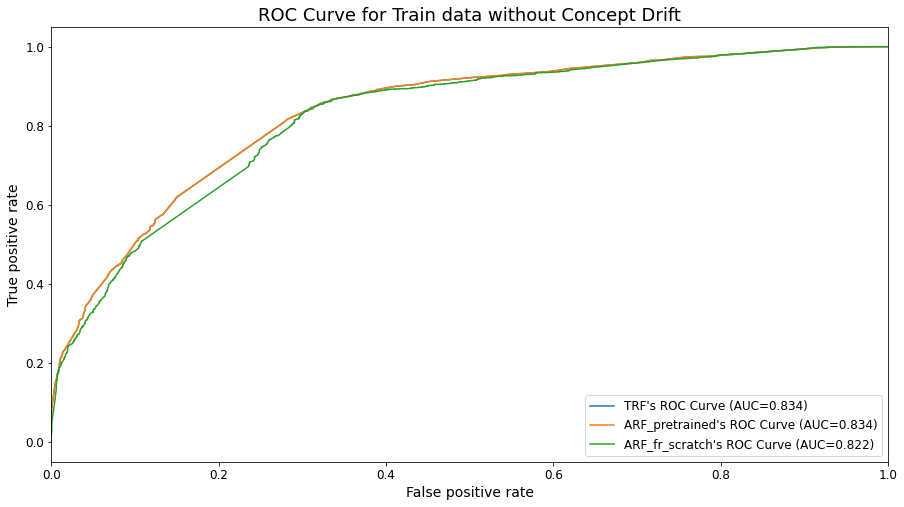

In [28]:
cf_pred_res['train']['model']['TRF'] = trf_cf
cf_pred_res['train']['model']['ARF_pretrained'] = arf_cf
cf_pred_res['train']['model']['ARF_fr_scratch'] = arf_cf_trained_fr_scratch

params = {
    'pred_records': cf_pred_res['train'],
    'X': X_train,
    'y': y_train,
    'data_pp': ls_data_pp,
    'plot_title': 'ROC Curve for Train data without Concept Drift'
}

measure_performance(**params)

## Test performance

The output compares the generalization performance between TRF and ARF in the offline setting. The output again proves that transfer learning process is **successful** as the ROC AUC score of both **TRF** and **pretrained ARF** is the same. The generalization performance of **ARF that is trained from scratch** is as good as the **pretrained ARF** with a negligible ROC AUC score difference of 1%.

Performing predictions: 100%|█████████████| 1305/1305 [00:02<00:00, 440.53it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0                0.810          0.810          0.809  0.672          0.672   
1                0.680          0.680          0.670  0.815          0.815   
macro avg        0.745          0.745          0.740  0.744          0.744   
weighted avg     0.750          0.750          0.745  0.738          0.738   

Metrics                     f1-score                               support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch     TRF   
0                     0.656    0.734          0.734          0.725   704.0   
1                     0.819    0.741          0.741          0.737   601.0   
macro avg             0.737    0.738          0.738          0.731  1305.0   
weighted avg          0.731    0.738          0.738          0.730  1305.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0                     704.0          704.0  
1                     601.0          601.0  
macro avg            1305.0         1305.0  
weighted avg         1305.0         1305.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.810,0.810,0.809,0.0,0.001,0.001
1,0.680,0.680,0.670,0.0,0.010,0.010
macro avg,0.745,0.745,0.740,0.0,0.005,0.005
weighted avg,0.750,0.750,0.745,0.0,0.005,0.005



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.672,0.672,0.656,0.0,0.016,0.016
1,0.815,0.815,0.819,0.0,-0.004,-0.004
macro avg,0.744,0.744,0.737,0.0,0.007,0.007
weighted avg,0.738,0.738,0.731,0.0,0.007,0.007



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0,0.734,0.734,0.725,0.0,0.009,0.009
1,0.741,0.741,0.737,0.0,0.004,0.004
macro avg,0.738,0.738,0.731,0.0,0.007,0.007
weighted avg,0.738,0.738,0.730,0.0,0.008,0.008


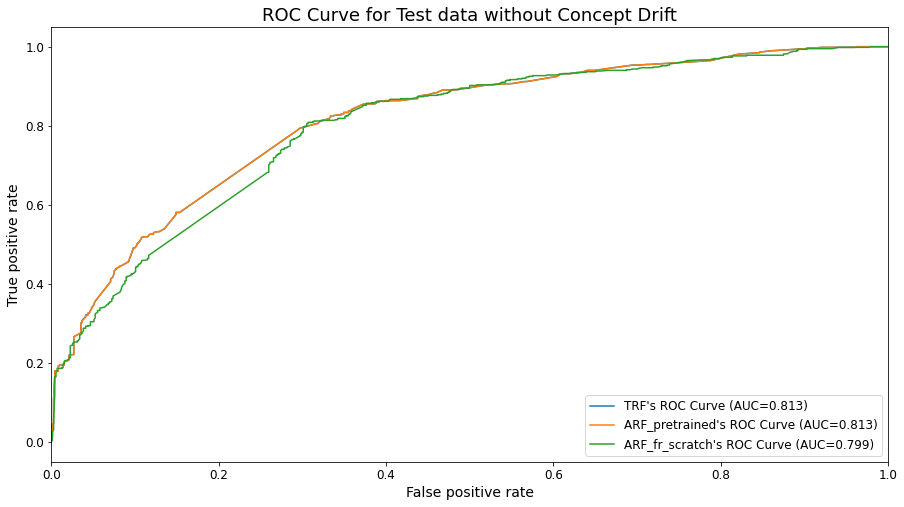

In [29]:
cf_pred_res['test']['model']['TRF'] = trf_cf
cf_pred_res['test']['model']['ARF_pretrained'] = arf_cf
cf_pred_res['test']['model']['ARF_fr_scratch'] = arf_cf_trained_fr_scratch

params = {
    'pred_records': cf_pred_res['test'],
    'X': X_test,
    'y': y_test,
    'data_pp': ls_data_pp,
    'plot_title': 'ROC Curve for Test data without Concept Drift'
}

measure_performance(**params)

The difference of ROC AUC in the offline set is calculated by substracting the training ROC AUC score with the testing ROC AUC score in the offline set.

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Diff ROC AUC in Offline set</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.834 - 0.813 = 0.021 (2.1%)</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.834 - 0.813 = 0.021 (2.1%)</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.822 - 0.799 = 0.023 (2.3%)</td>
    </tr>
</table>

The models do not suffer serious overfitting issues even if the hyperparameters used were the same as the ones in the experiment. 

Even though **ARF model that is trained from scratch** performs as good as **pre-trained ARF**, the **pre-trained ARF**'s base learners' tree structures are more consistent. For **ARF model that is trained from scratch**, the tree height of its base learners varies from 0 to 17. It means that some base learners only consist of shallow leaf nodes or one root leaf node. Hence, **ARF model trained from scratch** yield less stable predictions as compared to **pre-trained ARF**. A consistent tree structure are important since it ensures that every base learner can contribute accurate and reliable prediction probabilities before averaged and summed into ensemble prediction probabilites. This suggests one of the reasons why **ARF model trained from scratch** perform slightly worse as compared to other models.

In [30]:
models = {
    'TRF': trf_cf,
    'ARF_fr_scratch': arf_cf_trained_fr_scratch,
    'ARF_pretrained': arf_cf
}

analyze_trees(models)

1    2   3   4   5   6    7   8   9   10  11  \
Model          Properties                                                   
TRF            total_nodes   39   45  41  45  43  43   39  41  39  41  39   
               max_height     5    5   5   5   5   5    5   5   5   5   5   
ARF_fr_scratch total_nodes  117  113   1  89  71  73  113  49  39  47   9   
               max_height    17   13   0  12  10  10   18  10   7  12   4   
ARF_pretrained total_nodes   39   45  41  45  43  43   39  41  39  41  39   
               max_height     5    5   5   5   5   5    5   5   5   5   5   

                             12  13  14  15  16  17  18  19  20  
Model          Properties                                        
TRF            total_nodes   33  41  41  39  47  39  39  43  39  
               max_height     5   5   5   5   5   5   5   5   5  
ARF_fr_scratch total_nodes  105  89  23  19  55  45  11  99  87  
               max_height    14  13   5   6   8  10   5  13  11  
ARF_pretrained total_nodes   33  41  41  39  47  39  39  43  39  
               max_height     5   5   5   5   5   5   5   5   5


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Model,,,,,,,,,,,,,,,,,,,,
TRF,39,45,41,45,43,43,39,41,39,41,39,33,41,41,39,47,39,39,43,39
ARF_fr_scratch,117,113,1,89,71,73,113,49,39,47,9,105,89,23,19,55,45,11,99,87
ARF_pretrained,39,45,41,45,43,43,39,41,39,41,39,33,41,41,39,47,39,39,43,39



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Model,,,,,,,,,,,,,,,,,,,,
TRF,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
ARF_fr_scratch,17,13,0,12,10,10,18,10,7,12,4,14,13,5,6,8,10,5,13,11
ARF_pretrained,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


# Conclusion

As a conclusion, the pre-trained ARF is chosen as the application model because:
1. The performance of the pre-trained ARF classifier is better than TRF classifier during initial training. 
2. The performance of the ARF classifier is better than TRF classifier under the influence of data drift or concept drift. This has already proven in the experiment at *FYP2_ARF_CF_Performance_Analysis.ipynb*.
3. The pre-trained ARF classifier is chosen over ARF classifier that is trained from scratch since it can yield more stable predictions.

*Others*: The cell below trains the lead scoring model with the test samples and converts to dictionary in 10 increments. The purpose is to validate the tree SHAP explainer. The detail can be found in *FYP2_Explainer_Validation.ipynb*. 

In [31]:
from arf_to_dict_conversion import extract_cf_arf
from general_utils import serialize_arf
import json

# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_cf.pkl'), 'rb') as f:
    arf_cf_tmp = pickle.load(f)

X_test_d_pp = ls_data_pp.preprocess(X_test)
increment   = 10
checkpoints = np.linspace(0, len(X_test_d_pp), num=increment+1, endpoint=True).astype(np.int64)

EXP_DIR = 'outputs/explainer_validation/lead_scoring'
os.makedirs(EXP_DIR, exist_ok=True)

for idx in range(1, len(checkpoints)):
    start, end = (checkpoints[idx-1], checkpoints[idx])
    arf_cf_tmp, _ = train_arf_cf(arf_cf_tmp, X_test_d_pp[start:end], y_test[start:end])
    ls_arf_dict = extract_cf_arf(arf_cf_tmp, X_test_d_pp.columns.tolist())
    # Serialize the dictionary to convert to JSON
    ls_arf_dict_serializable = serialize_arf(ls_arf_dict)
    # Export to JSON
    with open(os.path.join(EXP_DIR, f'arf_cf_{idx}.json'), 'w') as f:
        json.dump(ls_arf_dict_serializable, f)

Training adaptive random forest algorithm: 100%|█| 130/130 [00:01<00:00, 78.42i
Training adaptive random forest algorithm: 100%|█| 131/131 [00:01<00:00, 93.66i
Training adaptive random forest algorithm: 100%|█| 130/130 [00:01<00:00, 92.55i
Training adaptive random forest algorithm: 100%|█| 131/131 [00:01<00:00, 84.91i
Training adaptive random forest algorithm: 100%|█| 130/130 [00:01<00:00, 91.69i
Training adaptive random forest algorithm: 100%|█| 131/131 [00:01<00:00, 96.08i
Training adaptive random forest algorithm: 100%|█| 130/130 [00:01<00:00, 106.63
Training adaptive random forest algorithm: 100%|█| 131/131 [00:01<00:00, 100.19
Training adaptive random forest algorithm: 100%|█| 130/130 [00:01<00:00, 101.96
Training adaptive random forest algorithm: 100%|█| 131/131 [00:01<00:00, 107.76
